# Default of Credit Card Clients 

### <font color="SpringGreen">Predicting the probability of credit card default</font>

# Dataset Information
This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

### Content
There are 25 variables:
<ul>
<li>ID: ID of each client</li>
<li>LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit</li>
<li>SEX: Gender (1=male, 2=female)</li>
<li>EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)</li>
<li>MARRIAGE: Marital status (1=married, 2=single, 3=others)</li>
<li>AGE: Age in years</li>
<li>PAY_0: Repayment status in September, 2005 </li>
    &nbsp;&nbsp;&nbsp;&nbsp; (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ...<br> &nbsp;&nbsp;&nbsp;&nbsp; 8=payment delay for eight months, 9=payment delay for nine months and above)
<li>PAY_2: Repayment status in August, 2005 (scale same as above)</li>
<li>PAY_3: Repayment status in July, 2005 (scale same as above)</li>
<li>PAY_4: Repayment status in June, 2005 (scale same as above)</li>
<li>PAY_5: Repayment status in May, 2005 (scale same as above)</li>
<li>PAY_6: Repayment status in April, 2005 (scale same as above)</li>
<li>BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)</li>
<li>BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)</li>
<li>BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)</li>
<li>BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)</li>
<li>BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)</li>
<li>BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)</li>
<li>PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)</li>
<li>PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)</li>
<li>PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)</li>
<li>PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)</li>
<li>PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)</li>
<li>PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)</li>
<li>default: Whether client defaults on payment (1=yes, 0=no)</li>
</ul>
    
### Source
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) at the UCI Machine Learning Repository.

### Relevant Reference
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

This notebook employs a binary variable, default payment, as the response variable. The goal is to understand the data and try to predict if a client will default (Yes = 1, No = 0) based on the other atttributes (explanatory variables like age, education, etc.) in the dataset.

## Imports
We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [401]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import researchpy as rp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Read in Data
First, we can list all the available data files. 

In [402]:
app_train = pd.read_csv('./data/UCI_Credit_Card.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Examine the Distribution of the Target Column
The target is what we are asked to predict: either a 0 for a credit card payment made on time, or a 1 indicating the client had payment difficulties (defaulted). We can first examine the number of loans falling into each category.

In [403]:
app_train['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

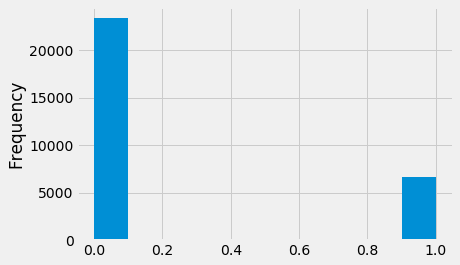

In [404]:
app_train['default'].astype(int).plot.hist();

From this information, we see this is an [imbalanced class](http://www.chioka.in/class-imbalance-problem/) problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can *weight* the classes by their representation in the data to reflect this imbalance.

## Examine Missing Values
Next we can look at the number and percentage of missing values in each column.

In [405]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [406]:
# Missing values statistics

missing_values = missing_values_table(app_train)
missing_values.head(10)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


If this dataset had missing values, when it came time to build our machine learning models, we would have to fill in these missing values (known as imputation). As an aside, some methods, such as [XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html), can handle [missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, it may be wise to keep all of the columns early on in EDA.

Examine Missing Values<br>
If we had missing values we could look at the number and percentage of missing values in each column as follows

In [407]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total non-missing values
        nonmis_val = df.notnull().sum()
    
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([nonmis_val, mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Non-Missing Values', 1 : 'Missing Values', 2 : '% of Total Values'})
       
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [408]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(10)


Your selected dataframe has 25 columns.
There are 25 columns that have missing values.


,Non-Missing Values,Missing Values,% of Total Values
ID,30000,0,0.0
BILL_AMT2,30000,0,0.0
PAY_AMT6,30000,0,0.0
PAY_AMT5,30000,0,0.0
PAY_AMT4,30000,0,0.0
PAY_AMT3,30000,0,0.0
PAY_AMT2,30000,0,0.0
PAY_AMT1,30000,0,0.0
BILL_AMT6,30000,0,0.0
BILL_AMT5,30000,0,0.0


## Column Types
Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features. 

In [409]:
# Number of each type of column
app_train.dtypes.value_counts()

int64    25
dtype: int64

### Encoding Categorical Variables
In this example we do not have any categorical variables, just integers. Well actually we do, but they have already been [encoded](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02): **Label encoding** assigns each unique category in a categorical variable with an integer. No new columns are created. For example, in education, 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown

As an alternative: **One-hot encoding** creates a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

If this hadn't been done alreay for us, the categorical variables would need to be dealt with before we went further. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to [encode](https://blog.cambridgespark.com/robust-one-hot-encoding-in-python-3e29bfcec77e) (represent) these variables as numbers before handing them off to the model. 

Additioanl resources to study:
- https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://www.kaggle.com/danavg/dummy-variables-vs-label-encoding-approach
- https://datascience.stackexchange.com/questions/36240/how-to-deal-with-nominal-categorical-with-label-encoding
- https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income

In [410]:
# # Number of unique classes in each object column
# app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

## Anomalies
One problem we always want to be on the lookout for when doing EDA is **anomalies** within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. 

One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. 

In [411]:
(app_train['AGE']).describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

Those ages look reasonable. There are no outliers for the age (e.g., a 2 year old with a credit card) on either the high or low end. How about balance limits?

In [412]:
app_train['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

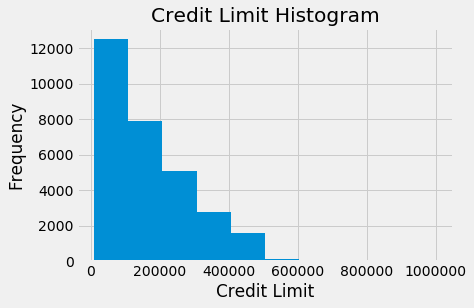

In [413]:
app_train['LIMIT_BAL'].plot.hist(title = 'Credit Limit Histogram');
plt.xlabel('Credit Limit');

This looks okay.  The data are positively skewed with most having a limit under 100,000 and a few individuals with a limit highter than 500,000.

## Correlations

#### Numerical
One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr dataframe` method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) of the absolute value of the correlation coefficent are:

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

#### Categorical
Two Categorical Variables:<br>
Checking if two categorical variables are independent can be done with Chi-Squared test of independence.

Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.  The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

For a typical **Chi-Square test**: we assume that two variables are independent, then the values of the contingency table for these variables should be distributed uniformly. And then we check how far away from uniform the actual values are.

There also exists a Crammer's V that is a measure of correlation that follows from this test.

#### Catetorical and Numerical
Categorical vs Numerical Variables: <br>
For this type we typically perform **one-way ANOVA test**: we calculate in-group variance and intra-group variance and then compare them.

#### [Contingency Tables](https://www.geeksforgeeks.org/contingency-table-in-python/) 
(Chi-squared test for categorical data)

In [414]:
pay_tab = pd.crosstab(app_train['PAY_0'], app_train['default'],  
                               margins = False) 
pay_tab

default,0,1
PAY_0,,
-2,2394,365
-1,4732,954
0,12849,1888
1,2436,1252
2,823,1844
3,78,244
4,24,52
5,13,13
6,5,6


Let's take a look at some of more significant correlations: PAY_0 (most recent repayment status) is the most positive correlation.

In [415]:
sex_tab = pd.crosstab(app_train['SEX'], app_train['default'],  
                               margins = True) 
sex_tab

default,0,1,All
SEX,,,
1,9015,2873,11888
2,14349,3763,18112
All,23364,6636,30000


In [416]:
edu_tab = pd.crosstab(app_train['EDUCATION'], app_train['default'],  
                               margins = False) 
edu_tab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


We can calculate the expected frequency of observations in each default group and see whether the partitioning of interests by Sex results in similar or different frequencies.  

We assume (**null hypothesis**, $H_O$) that the observed frequencies for a categorical variable match the expected frequencies for the categorical variable. 

In other words, the **null hypothesis** of the Chi-Square test is that *no* relationship exists on the categorical variables in the population; they are *independent*.  We "*reject*" or "*fail to reject*" the $H_O$ based on the test statistics.

In [417]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# contingency table
table = sex_tab
print(table,"\n")
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d\n' % dof)
print(expected,"\n")

# interpret test-statistic
print("interpret test-statistic")
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)\n')
else:
    print('Independent (fail to reject H0)\n')
    
# interpret p-value
print("interpret p-value")
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

default      0     1    All
SEX                        
1         9015  2873  11888
2        14349  3763  18112
All      23364  6636  30000 

dof=4

[[ 9258.3744  2629.6256 11888.    ]
 [14105.6256  4006.3744 18112.    ]
 [23364.      6636.     30000.    ]] 

interpret test-statistic
probability=0.950, critical=9.488, stat=47.905
Dependent (reject H0)

interpret p-value
significance=0.050, p=0.000
Dependent (reject H0)


Similar for education

In [418]:
# contingency table
table = edu_tab
print(table,"\n")
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d\n' % dof)
print(expected,"\n")

# interpret test-statistic
print("interpret test-statistic")
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)\n')
else:
    print('Independent (fail to reject H0)\n')
    
# interpret p-value
print("interpret p-value")
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

default        0     1
EDUCATION             
0             14     0
1           8549  2036
2          10700  3330
3           3680  1237
4            116     7
5            262    18
6             43     8 

dof=6

[[1.0903200e+01 3.0968000e+00]
 [8.2435980e+03 2.3414020e+03]
 [1.0926564e+04 3.1034360e+03]
 [3.8293596e+03 1.0876404e+03]
 [9.5792400e+01 2.7207600e+01]
 [2.1806400e+02 6.1936000e+01]
 [3.9718800e+01 1.1281200e+01]] 

interpret test-statistic
probability=0.950, critical=12.592, stat=163.217
Dependent (reject H0)

interpret p-value
significance=0.050, p=0.000
Dependent (reject H0)


and for pay_0

In [419]:
# contingency table
table = pay_tab
print(table,"\n")
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d\n' % dof)
print(expected,"\n")

# interpret test-statistic
print("interpret test-statistic")
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)\n')
else:
    print('Independent (fail to reject H0)\n')
    
# interpret p-value
print("interpret p-value")
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

default      0     1
PAY_0               
-2        2394   365
-1        4732   954
 0       12849  1888
 1        2436  1252
 2         823  1844
 3          78   244
 4          24    52
 5          13    13
 6           5     6
 7           2     7
 8           8    11 

dof=10

[[2.14870920e+03 6.10290800e+02]
 [4.42825680e+03 1.25774320e+03]
 [1.14771756e+04 3.25982440e+03]
 [2.87221440e+03 8.15785600e+02]
 [2.07705960e+03 5.89940400e+02]
 [2.50773600e+02 7.12264000e+01]
 [5.91888000e+01 1.68112000e+01]
 [2.02488000e+01 5.75120000e+00]
 [8.56680000e+00 2.43320000e+00]
 [7.00920000e+00 1.99080000e+00]
 [1.47972000e+01 4.20280000e+00]] 

interpret test-statistic
probability=0.950, critical=18.307, stat=5365.965
Dependent (reject H0)

interpret p-value
significance=0.050, p=0.000
Dependent (reject H0)


### Encoding categorical data -- an aside

You can also [skip to the end](#End-encoding) of this section to get back to chi-squared test.

In [420]:
def order_cat(df,col,order):
    df[col]=df[col].astype('category')
    df[col]=df[col].cat.reorder_categories(order,ordered=True)
    df[col]=df[col].cat.codes.astype(int)
    
def check_count(var,df):
    return(sorted(df[var].unique()))

<font color="red">NOTE</font>  We are going to convert the numeric encoded values back to nominal.  This is just an exercise to show how to use encoding in scikit-learn

In [421]:
cat_data = app_train[["SEX","EDUCATION", "MARRIAGE","PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6","default"]]
cat_data.rename(columns=lambda x:x.lower(),inplace=True)
cat_data.head()

,sex,education,marriage,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default
0,2,2,1,2,2,-1,-1,-2,-2,1
1,2,2,2,-1,2,0,0,0,2,1
2,2,2,2,0,0,0,0,0,0,0
3,2,2,1,0,0,0,0,0,0,0
4,1,2,1,-1,0,-1,0,0,0,0


In [422]:
cat_data['sex'] = np.where((cat_data.sex == 1),'male',cat_data.sex)
cat_data['sex'] = np.where((cat_data.sex == '2'),'female',cat_data.sex)

cat_data['marriage'] = np.where((cat_data.marriage == 1),'married',cat_data.marriage)
cat_data['marriage'] = np.where((cat_data.marriage == '2'),'single',cat_data.marriage)
cat_data['marriage'] = np.where((cat_data.marriage == '3'),'other',cat_data.marriage)
cat_data['marriage'] = np.where((cat_data.marriage == '0'),'other',cat_data.marriage)

cat_data['education'] = np.where((cat_data.education == 1),'grad_school',cat_data.education)
cat_data['education'] = np.where((cat_data.education == "2"),'university',cat_data.education)
cat_data['education'] = np.where((cat_data.education == "3"),'high_school',cat_data.education)
cat_data['education'] = np.where((cat_data.education == "4"),'other',cat_data.education)
cat_data['education'] = np.where((cat_data.education == "5"),'unknown',cat_data.education)
cat_data['education'] = np.where((cat_data.education == "6"),'unknown',cat_data.education)
cat_data['education'] = np.where((cat_data.education == "0"),'unknown',cat_data.education)

cat_data['default'] = np.where((cat_data.default == 0),'no',cat_data.default)
cat_data['default'] = np.where((cat_data.default == '1'),'yes',cat_data.default)

cat_data

,sex,education,marriage,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default
0,female,university,married,2,2,-1,-1,-2,-2,yes
1,female,university,single,-1,2,0,0,0,2,yes
2,female,university,single,0,0,0,0,0,0,no
3,female,university,married,0,0,0,0,0,0,no
4,male,university,married,-1,0,-1,0,0,0,no
...,...,...,...,...,...,...,...,...,...,...
29995,male,high_school,married,0,0,0,0,0,0,no
29996,male,high_school,single,-1,-1,-1,-1,0,0,no
29997,male,university,single,4,3,2,-1,0,0,yes
29998,male,high_school,married,1,-1,0,0,0,-1,yes


In [423]:
pay_features=['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']

for p in pay_features:
    cat_data.loc[cat_data[p]<0,p]=0

cat_data['pay_0'] = np.where((cat_data.pay_0 == 0),'paid_on_time',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '1'),'paid_1month_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '2'),'paid_2months_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '3'),'paid_3months_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '4'),'paid_4months_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '5'),'paid_5months_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '6'),'paid_6months_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '7'),'paid_7months_late',cat_data.pay_0)
cat_data['pay_0'] = np.where((cat_data.pay_0 == '8'),'paid_8months_late',cat_data.pay_0)

cat_data['pay_2'] = np.where((cat_data.pay_2 == 0),'paid_on_time',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '1'),'paid_1month_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '2'),'paid_2months_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '3'),'paid_3months_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '4'),'paid_4months_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '5'),'paid_5months_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '6'),'paid_6months_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '7'),'paid_7months_late',cat_data.pay_2)
cat_data['pay_2'] = np.where((cat_data.pay_2 == '8'),'paid_8months_late',cat_data.pay_2)

cat_data['pay_3'] = np.where((cat_data.pay_3 == 0),'paid_on_time',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '1'),'paid_1month_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '2'),'paid_2months_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '3'),'paid_3months_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '4'),'paid_4months_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '5'),'paid_5months_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '6'),'paid_6months_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '7'),'paid_7months_late',cat_data.pay_3)
cat_data['pay_3'] = np.where((cat_data.pay_3 == '8'),'paid_8months_late',cat_data.pay_3)

cat_data['pay_4'] = np.where((cat_data.pay_4 == 0),'paid_on_time',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '1'),'paid_1month_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '2'),'paid_2months_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '3'),'paid_3months_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '4'),'paid_4months_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '5'),'paid_5months_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '6'),'paid_6months_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '7'),'paid_7months_late',cat_data.pay_4)
cat_data['pay_4'] = np.where((cat_data.pay_4 == '8'),'paid_8months_late',cat_data.pay_4)

cat_data['pay_5'] = np.where((cat_data.pay_5 == 0),'paid_on_time',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '1'),'paid_1month_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '2'),'paid_2months_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '3'),'paid_3months_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '4'),'paid_4months_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '5'),'paid_5months_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '6'),'paid_6months_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '7'),'paid_7months_late',cat_data.pay_5)
cat_data['pay_5'] = np.where((cat_data.pay_5 == '8'),'paid_8months_late',cat_data.pay_5)

cat_data['pay_6'] = np.where((cat_data.pay_6 == 0),'paid_on_time',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '1'),'paid_1month_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '2'),'paid_2months_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '3'),'paid_3months_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '4'),'paid_4months_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '5'),'paid_5months_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '6'),'paid_6months_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '7'),'paid_7months_late',cat_data.pay_6)
cat_data['pay_6'] = np.where((cat_data.pay_6 == '8'),'paid_8months_late',cat_data.pay_6)

cat_data.head()

,sex,education,marriage,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default
0,female,university,married,paid_2months_late,paid_2months_late,paid_on_time,paid_on_time,paid_on_time,paid_on_time,yes
1,female,university,single,paid_on_time,paid_2months_late,paid_on_time,paid_on_time,paid_on_time,paid_2months_late,yes
2,female,university,single,paid_on_time,paid_on_time,paid_on_time,paid_on_time,paid_on_time,paid_on_time,no
3,female,university,married,paid_on_time,paid_on_time,paid_on_time,paid_on_time,paid_on_time,paid_on_time,no
4,male,university,married,paid_on_time,paid_on_time,paid_on_time,paid_on_time,paid_on_time,paid_on_time,no


In [424]:
X = cat_data.iloc[:, :-1]
y = cat_data.iloc[:, -1]

We can use the OrdinalEncoder() from scikit-learn to encode each variable to integers. This is a flexible class and does allow the order of the categories to be specified as arguments if any such order is known.

Yes, I know we are undoing what we did above, but this is just for showing how to code things if we started with a less clean dataset

In [425]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

[Label vs. Ordinal Encoders](https://stackoverflow.com/questions/54440507/encoding-ordinal-values-in-python)

[OrdinalEncoder Help](https://stackoverflow.com/questions/53295208/specifying-the-order-of-encoding-in-ordinal-encoder)

[Sklearn OrdinalEncoder](https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9)

In [426]:
#Prepare input variable (independent variables)

X_enc = X.copy()

oe = OrdinalEncoder(categories=[['unknown', 'other', 'high_school', 'university', 'grad_school']])
X_enc.education = oe.fit_transform(X.education.values.reshape(-1, 1))

pay_cats = ['paid_on_time', 'paid_1month_late', 'paid_2months_late', 
                                 'paid_3months_late', 'paid_4months_late',
                                 'paid_5months_late', 'paid_6months_late',
                                 'paid_7months_late', 'paid_8months_late']

oe = OrdinalEncoder(categories=[pay_cats,pay_cats,pay_cats,pay_cats,pay_cats,pay_cats])
X_enc.iloc[:,3:] = oe.fit_transform(X.iloc[:,3:])

oe = OrdinalEncoder()
X_enc[['sex','marriage']] = oe.fit_transform(X[['sex','marriage']])

#oe.categories_



In [427]:
X_enc

,sex,education,marriage,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
0,0.0,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
1,0.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0
2,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
29995,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,1.0,3.0,2.0,4.0,3.0,2.0,0.0,0.0,0.0
29998,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [428]:
# Prepare target

y_enc = y.copy()

le = LabelEncoder()
y_enc = le.fit_transform(y)


In [429]:
y_enc

array([1, 1, 0, ..., 1, 1, 1])

### End encoding

### chi-squared (chi2)

The scikit-learn machine library also provides an implementation of the chi-squared test in the chi2() function. This function can be used in a **feature selection strategy**, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

For example, we can define the SelectKBest class to use the chi2() function and select all features, then transform the train and test sets.

In [430]:
# split into train and test sets -- use 75% of the data for training and 25% for testing.
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.25, random_state=1)

In [431]:
# summarize
print('Train', X_train_enc.shape, y_train_enc.shape)
print('Test', X_test_enc.shape, y_test_enc.shape)

Train (22500, 9) (22500,)
Test (7500, 9) (7500,)


In [432]:
# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

### Selection strategy
Outcome....

Feature 0: 16.234230
Feature 1: 3.564257
Feature 2: 20.810206
Feature 3: 5756.642705
Feature 4: 4970.090561
Feature 5: 3822.148800
Feature 6: 3678.842810
Feature 7: 3543.233511
Feature 8: 2958.710178


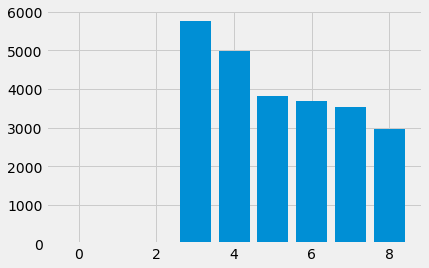

In [446]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Running the example first prints the scores calculated for each input feature and the target variable.

Note: your specific results may differ. Try running the example a few times.

In some cases it may be hard to get an idea from the number alone as to which features are more relevant.

Perhaps the repayment featrues are most relevant (especially the most recent repayment, pay_0).

A bar chart of the feature importance scores for each input feature  was also created above.

This clearly shows that features 3 (pay_0) and 4 (pay_2) might be the most relevant with sex, marriage, and education being little relevant.

We could set k=4 (vs. =all) when configuring the SelectKBest to select the top four features.

#### ANOVA Assumptions

- Normality
    * Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality
- Homogeneity of variance
    * Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation
- Independent observations

#### Hypotheses
- $H_0$: No difference between means
- $H_a$: Difference between means exist somewhere

If the p-value is less than or equal to the significance level, you reject the null hypothesis and conclude that not all of population means are equal. 

If the p-value is greater than the significance level, you do not have enough evidence to reject the null hypothesis that the population means are all equal.

For $p < 0.05$, we will reject the null hypothesis

<font color="red">NOTE</font><br>
Below we just show the functions you can use.  This exercise doesn't really make sense/isn't useful to the analysis.  Just an example to show the mechanics.

In [72]:
rp.summary_cont(app_train['AGE'].groupby(app_train['default']))

,N,Mean,SD,SE,95% Conf.,Interval
default,,,,,,
0,23364,35.417266,9.077355,0.059386,35.300866,35.533665
1,6636,35.725738,9.693438,0.118994,35.492493,35.958984


In [73]:
rp.summary_cont(app_train['LIMIT_BAL'].groupby(app_train['default']))

,N,Mean,SD,SE,95% Conf.,Interval
default,,,,,,
0,23364,178099.726074,131628.359660,861.144179,176411.847361,179787.604787
1,6636,130109.656420,115378.540571,1416.354128,127333.393139,132885.919700


In [78]:
stats.f_oneway(app_train['AGE'][app_train['default'] == 0], 
             app_train['AGE'][app_train['default'] == 1])

F_onewayResult(statistic=5.788555824672056, pvalue=0.016136845890286453)

In [80]:
stats.f_oneway(app_train['LIMIT_BAL'][app_train['default'] == 0], 
             app_train['LIMIT_BAL'][app_train['default'] == 1])

F_onewayResult(statistic=724.0685392611651, pvalue=1.3022439532706416e-157)

In [102]:
results = ols('AGE ~ C(default)', data=app_train).fit()
#results.summary()

In [101]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(AGE),27.313997,55.0,2.892687,5.163895e-12
Residual,5140.802803,29944.0,NaN,NaN


In [96]:
results = ols('LIMIT_BAL ~ C(default)', data=app_train).fit()
#results.summary()

In [97]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(default),1.190241e+13,1.0,724.068539,1.302244e-157
Residual,4.931144e+14,29998.0,NaN,NaN


#### Histogram of age

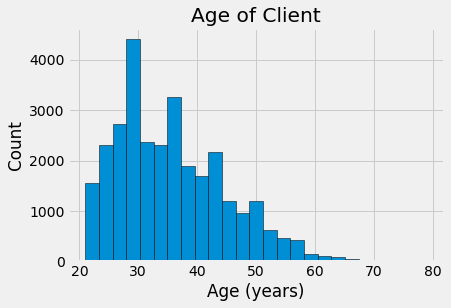

In [95]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['AGE'], edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

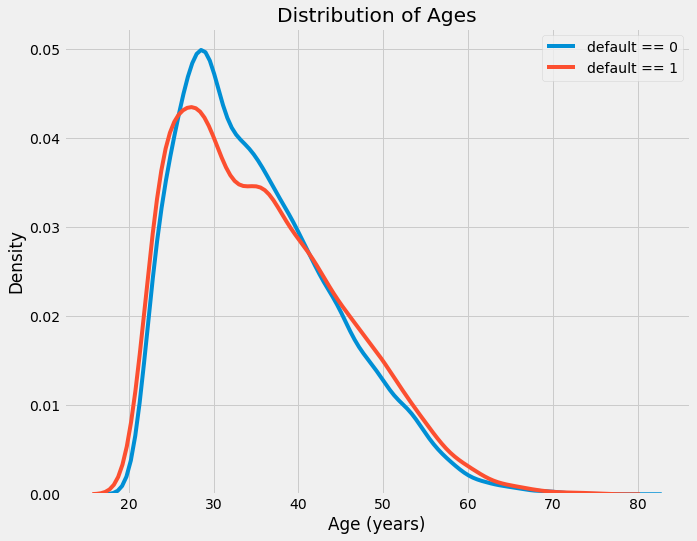

In [104]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['default'] == 0, 'AGE'], label = 'default == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['default'] == 1, 'AGE'], label = 'default == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The default == 0 (no default) curve skews slightly towards the younger end of the range. Let's look at this relationship in another way: average failure to pay credit card debt by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [106]:
# Age information into a separate dataframe
age_data = app_train[['default', 'AGE']]

# Bin the age data
age_data['AGE_BINNED'] = pd.cut(age_data['AGE'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,default,AGE,AGE_BINNED
0,1,24,"(20.0, 25.0]"
1,1,26,"(25.0, 30.0]"
2,0,34,"(30.0, 35.0]"
3,0,37,"(35.0, 40.0]"
4,0,57,"(55.0, 60.0]"
5,0,37,"(35.0, 40.0]"
6,0,29,"(25.0, 30.0]"
7,0,23,"(20.0, 25.0]"
8,0,28,"(25.0, 30.0]"
9,0,35,"(30.0, 35.0]"


In [107]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('AGE_BINNED').mean()
age_groups

,default,AGE
AGE_BINNED,,
"(20.0, 25.0]",0.266598,23.724619
"(25.0, 30.0]",0.201484,28.056847
"(30.0, 35.0]",0.194272,32.964803
"(35.0, 40.0]",0.216189,37.885499
"(40.0, 45.0]",0.221359,42.859085
"(45.0, 50.0]",0.250417,47.847083
"(50.0, 55.0]",0.247719,52.776140
"(55.0, 60.0]",0.263986,57.543706
"(60.0, 65.0]",0.268817,62.586022


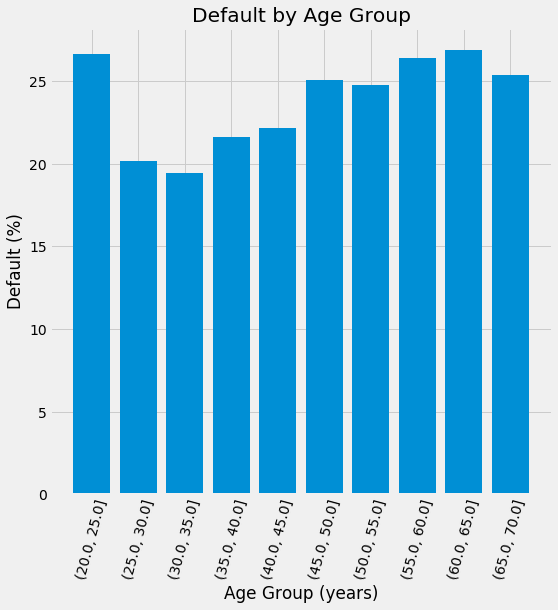

In [112]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['default'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Default (%)')
plt.title('Default by Age Group');

The trend appears to be that the youngest and oldest applicants are more likely to default! Perhaps the youngest do not yet have well-paying jobs and the older are on fixed (retirement) budgets and have less money.

This is information that could be directly used by the bank: clients in age groups more likely to default, maybe  should be provided with more guidance or financial planning tips.

# Next Steps in Modeling

Now that we've explored and better understand the data...

Let's clean things up a bit and try a model

### Cleaning

In [113]:
data = app_train.copy()

In [114]:
data.drop(['ID'],axis=1,inplace=True)
data.rename(columns=lambda x:x.lower(),inplace=True)
data.rename(columns={'default.payment.next.month':'default'},inplace=True)
data.head()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [118]:
#Remind ourselves of how many no-default to default responses we have 
#(hint: ~78% 0 (no) responses and ~22% 1 (yes))

print(data.default.value_counts().index[0],
      (data.default.value_counts()[0]/len(data)*100))
print(data.default.value_counts().index[1], 
      (data.default.value_counts()[1]/len(data)*100))

0 77.88000000000001
1 22.12


### Model building and Evaluation in Scikit-learn

The code below is an example of logistic regression in Python using `scikit-learn`.  At the end, to improve our initial results, we show grid search using `GridSearchCV` (also from the `scikit-learn` library).

**What is grid search?**
Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model.  More on this [below](#GridSearchCV).

First split the columns in our dataframe into input (X) and output (y) for modeling.

In [122]:
from sklearn.preprocessing import RobustScaler

scaler=RobustScaler()

label='default'
X=data.drop(label,axis=1)

features=X.columns

X=scaler.fit_transform(X)
y=data[label]

**Functions**<br>
Define some functions we can use

It is useful to tie tie steps together into helpful functions so that we can reuse later.

In [123]:
def CFMatrix(cm,labels=['pay','default']):
    df=pd.DataFrame(data=cm,index=labels,columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total']=df.sum()
    df['Total']=df.sum(axis=1)
    return df

In [124]:
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix

def predict(model,X_test,y_test):
    
    pred=model.predict(X_test)
    
    acc_score=accuracy_score(y_pred=pred,y_true=y_test)
    precision=precision_score(y_pred=pred,y_true=y_test)
    recall=recall_score(y_pred=pred,y_true=y_test)

    print('Acc Score:',acc_score)
    print('Precission: ',precision)
    print('Recall: ',recall)
    
    return CFMatrix(confusion_matrix(y_pred=pred,y_true=y_test))

In [125]:
from sklearn.metrics import roc_auc_score,roc_curve

def plot_roc_curve(model,X_test,y_test):
    
    log_roc_auc=roc_auc_score(y_test,model.predict(X_test))
    
    fpr,tpr,thresholds=roc_curve(y_test,model.predict_proba(X_test)[:,1])
    
    plt.figure()
    plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)'%log_roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posiive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    return

In [126]:
from sklearn.metrics import precision_recall_curve

def recall_to_precision(model,X_test,y_test):
    precision_p,recall_p,thresholds=precision_recall_curve(y_true=y_test,probas_pred=model.predict_proba(X_test)[:,1])

    fig,ax=plt.subplots(figsize=(8,5))

    ax.plot(thresholds,precision_p[1:],label='Precision')
    ax.plot(thresholds,recall_p[1:],label='Recall')

    ax.set_xlabel('Classification Threshold')
    ax.set_ylabel('Precision, Recall')
    ax.set_title('Logistic Regression Classifier: Precision-Recall')
    ax.hlines(y=0.6,xmin=0,xmax=1,color='red')
    ax.legend()
    ax.grid();
    return

In [127]:
def predict_threshold(model,X_test,y_test,threshold):
    pred_02_prob=model.predict_proba(X_test)[:,1]

    pred_02= (pred_02_prob >= threshold).astype('int')

    acc_score=accuracy_score(y_pred=pred_02,y_true=y_test)
    precision=precision_score(y_pred=pred_02,y_true=y_test)
    recall=recall_score(y_pred=pred_02,y_true=y_test)

    print('Acc Score:',acc_score)
    print('Precission: ',precision)
    print('Recall: ',recall)

    return CFMatrix(confusion_matrix(y_pred=pred_02,y_true=y_test))

In [128]:
# Feature importance
def plot_feature_imp(model,features):
    
    df=pd.DataFrame({'features':features.tolist(),'relation':model.coef_.reshape(X_train.shape[1]).tolist()})
    df=df.sort_values(by='relation',ascending=False)
    
    p_pos= np.arange(len(df.loc[df['relation']>=0,'relation']))
    n_pos= np.arange(len(p_pos),len(p_pos)+len(df.loc[df['relation']<0,'relation']))
    
    plt.figure(figsize=(13,16))
    plt.barh(p_pos,df.loc[df['relation']>=0,'relation'])
    plt.barh(n_pos,df.loc[df['relation']<0,'relation'])
    plt.yticks(np.arange(len(p_pos)+len(n_pos)),df['features'].tolist())
    plt.title('Feature Coefficents with respect to Label')
    plt.show()
    return

### Model: First Attempt


### Metrics and Evaluation Primer

Before going into the steps to execute a logistic regression classifier in scikit-learn, let's review some basics on how to evaluate your model.

When making a prediction for a binary or two-class classification problem, there are two types of errors that we could make.

- **False Positive**. Predict an event (true) when there was no event (false).
- **False Negative**. Predict no event (false) when in fact there was an event (true).

By predicting probabilities and calibrating a threshold, a balance of these two concerns can be chosen by the operator of the model.

A common way to compare models that predict probabilities for two-class problems is to use a **Receiver Operating Characteristic curve (ROC) curve**.

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

Let’s review how to interpret the **ROC plot**:

- A **true positive** is a true observation correctly predicted to be true.
- The **true-positive rate (TPR)** is the number of true positives / ground truth positives. 
>$True Positive Rate = True Positives / (True Positives + False Negatives)$
- A **true negative** is an observation labeled as negative that is actually negative.
- The false-positive rate (FPR) is the number of false positives / ground truth negatives. 
>$False Positive Rate = False Positives / (False Positives + True Negatives)$

We put the TPR on the left axis and the FPR on the bottom axis. And we also plot the 45º line as a dashed line. The 45º line is the ROC curve you would get if you classified your observations randomly using the base rate.

Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

As you may have figured out, the closer the ROC curve reaches to the top left corner, the better the test.
We quantify a model’s ROC curve by calculating the total **Area Under the Curve (AUC)**, a metric which falls between 0 and 1 with a higher number indicating better classification performance. In the graph above, the AUC for the blue curve will be greater than that for the red curve, meaning the blue model is better at achieving a blend of precision and recall. A random classifier (the black line) achieves an AUC of 0.5.

A skilful model will assign a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. This is what we mean when we say that the model has **skill**. Generally, skilful models are represented by curves that bow up to the top left of the plot.

A **no-skill classifier** is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. A model with no skill is represented at the point (0.5, 0.5). A model with no skill at each threshold is represented by a diagonal line from the bottom left of the plot to the top right and has an AUC of 0.5.

ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability [thresholds](#Threshold-(Additional-Evaluation-Considerations).

**Precision-Recall** summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

- **Precision** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.
>$Precision = True Positives / (True Positives + False Positives)$
- **Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity and true-positive rate.
>$Recall = True Positives / (True Positives + False Negatives)$

What happens if you can’t decide how to balance the false positives and false negatives on your business case?
A frequently used metric is the **F1-score**, which is the harmonic mean of **precision** and **recall**.

![](./images/Fscore.png "F1-score Equation")
![](./images/confusionmatrix.png "Confusion Matrix")

### Summary of terms


**Four Outcomes of Binary Classification**

- True positives: data points labeled as positive that are actually positive
- False positives: data points labeled as positive that are actually negative
- True negatives: data points labeled as negative that are actually negative
- False negatives: data points labeled as negative that are actually positive

**Recall and Precision Metrics**

- Recall: ability of a classification model to identify all relevant instances
- Precision: ability of a classification model to return only relevant instances
- F1 score: single metric that combines recall and precision using the harmonic mean

**Visualizing Recall and Precision**

- Receiver operating characteristic (ROC) curve: plots the true positive rate (TPR) versus the false positive rate (FPR) as a function of the model’s threshold for classifying a positive
- Area under the curve (AUC): metric to calculate the overall performance of a classification model based on area under the ROC curve

**Split data into Test & Train**

We split the data into training and test sets so that we can fit and evaluate a learning model.

Rationale:
- Split the dataset into two pieces, so that the model can be trained and tested on different data
- Better estimate of out-of-sample performance, but still a "high variance" estimate
- Useful due to its speed, simplicity, and flexibility

We will use the `train_test_split()` function form `scikit-learn` and use 85% of the data for training and 15% for testing.

In [129]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=99,stratify=y)

from sklearn.linear_model import LogisticRegression

model= LogisticRegression(random_state=0)

model.fit(X_train,y_train)

predict(model,X_test,y_test)

Acc Score: 0.8126666666666666
Precission:  0.7389937106918238
Recall:  0.23618090452261306


PREDICTION,pay,default,Total
TRUE,,,
pay,3422,83,3505
default,760,235,995
Total,4182,318,4500


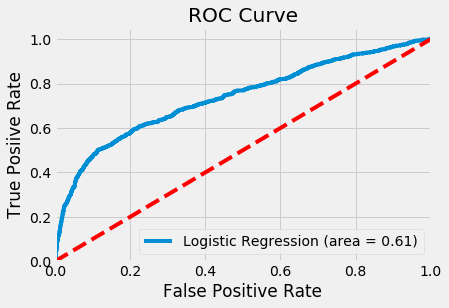

In [130]:
plot_roc_curve(model,X_test,y_test)

the ROC curve above shows 0.6 for AUC score.

### Threshold (Additional Evaluation Considerations)

In the real world, business doesn't care about [metrics](#Metrics-and-Evaluation-Primer), but about outcomes.  Your job as a data scientist isn’t done until you explain how to interpret the model and apply it. That means threshold selection for the business decision that motivated the model.

Threshold selection is necessary in the context of an algorithm which predicts the probability that an observation will belong to the positive class. The question then becomes, if we need to make discrete predictions based on the modeled probability, what is the best threshold to classify an observation as positive?

You need to first consider the cost of type I and type II errors for your business problem? What is the marginal cost of a false positive, and what is the marginal cost of a false negative? 

Select the threshold that minimizes the total cost of false positives and false negatives in cross-validation. 

The ROC curve shows how the recall vs precision relationship changes as we vary the threshold for identifying a positive in our model. The threshold represents the value above which a data point is considered in the positive class. If we have a model for identifying a disease, our model might output a score for each patient between 0 and 1 and we can set a threshold in this range for labeling a patient as having the disease (a positive label). By altering the threshold, we can try to achieve the right precision vs recall balance.

For a given model, we can only travel along one curve, but we can move along that curve by adjusting our threshold for classifying a positive case. Generally, as we decrease the threshold, we move to the right and upwards along the curve. 

Starting in the lower left of the ROC graph we would be at a threshold of 1.0 because we identify no data points as positives leading to no true positives and no false positives (TPR = FPR = 0).  As we decrease the threshold, we identify more data points as positive, leading to more true positives, but also more false positives (the TPR and FPR increase). Eventually, at a threshold of 0.0 we identify all data points as positive and find ourselves in the upper right corner of the ROC curve (TPR = FPR = 1.0).

If you're confused the logistic regression curve images below may help clarify:

![](./images/threshold.png "Explanation of Threshold")

**Summary**<br>
If the cost of a false negative is higher, you need a low threshold to minimize false negatives.  If you need to instead minimize false positives, you want a higher threshold.

**Case**<br>
For our example here -- when predicting whether a client will default on a credit card, extending credit that should have been denied could cost a lot in credit losses and administrative costs. Denying credit that should have been extended would likely result in lesser losses. Pick the threshold that gives the lowest total cost risk (i.e., better to deny credit to a non-defaulter than extend credit to a defaulter).




We want ot minimize the False Negative rate with respect to True positive, because we don't wan't to classify any person who is potential defaulter to be classified as non-defaulter. We can tolerate with some False Positive cases i.e. Non defaulters classified as defaulters. So we require high Recall rate, so lets compare the model to find true positive with respect to false positive rate

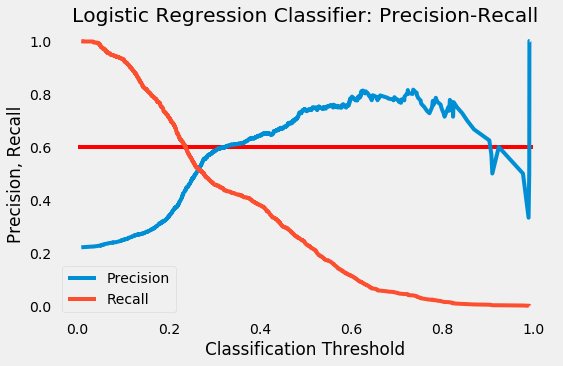

In [131]:
recall_to_precision(model,X_test,y_test)

So from graph we can see with threshold of 0.2 we can can get Recall of 60%.
So lets now predict the test data with threshold of 0.2.


In [132]:
predict_threshold(model,X_test,y_test,0.2)

Acc Score: 0.6288888888888889
Precission:  0.3385939741750359
Recall:  0.7115577889447237


PREDICTION,pay,default,Total
TRUE,,,
pay,2122,1383,3505
default,287,708,995
Total,2409,2091,4500


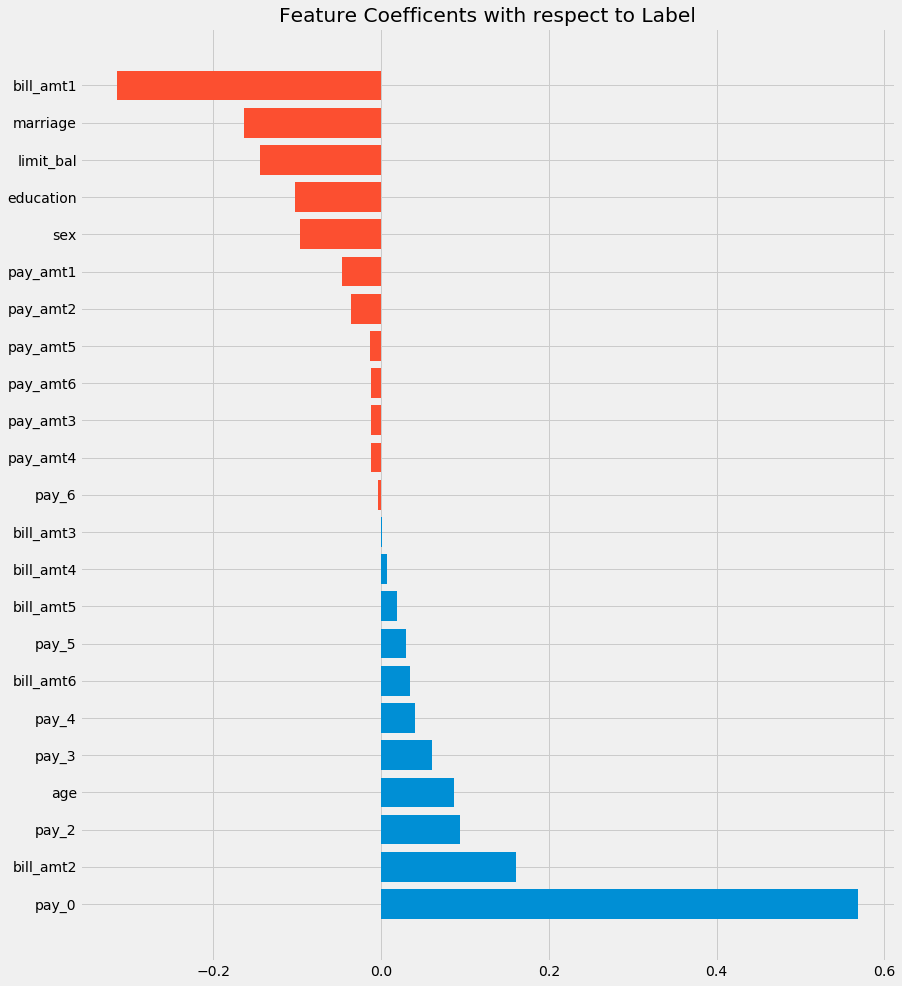

In [133]:
plot_feature_imp(model,features)

### Tuning the model

### GridSearchCV

Using grid search in scikit-learn.

A list of values (param_grid) to choose from is given to each hyper parameter of the model. You can change these values and experiment more to see which value ranges give better performance. A [cross validation process](https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833) is performed in order to determine the hyper parameter value set which provides the best accuracy levels.

Once we have that, we use the best set of hyper parameter values chosen in the grid search, in the actual model as shown below.

In [158]:
dual=[True,False]
max_iter=[100,110,120,130,140]
penalty=['l1','l2']
C=np.logspace(-4,4,20)
class_weight=['balanced']
solver=['saga']

#option 1 -- better accuracy
param_grid=dict(dual=dual,max_iter=max_iter,penalty=penalty,C=C,class_weight=class_weight,solver=solver)

#option 2 -- faster run time, lower accuracy
#param_grid=dict(max_iter=max_iter,penalty=penalty,class_weight=class_weight,solver=solver)


In [159]:
from sklearn.model_selection import GridSearchCV

grid=GridSearchCV(estimator=model,param_grid=param_grid,cv=4,n_jobs=-1)
grid.fit(X_train,y_train);

In [160]:
tuned_model=grid.best_estimator_
tuned_model

LogisticRegression(C=0.0006951927961775605, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [161]:
predict(tuned_model,X_test,y_test)

Acc Score: 0.7886666666666666
Precission:  0.5225872689938398
Recall:  0.5115577889447236


PREDICTION,pay,default,Total
TRUE,,,
pay,3040,465,3505
default,486,509,995
Total,3526,974,4500


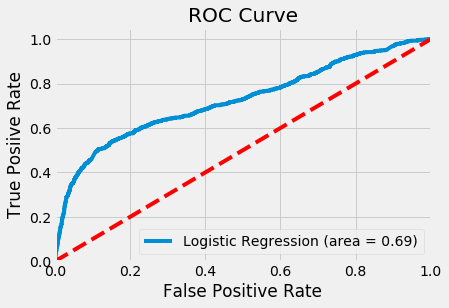

In [162]:
plot_roc_curve(tuned_model,X_test,y_test)

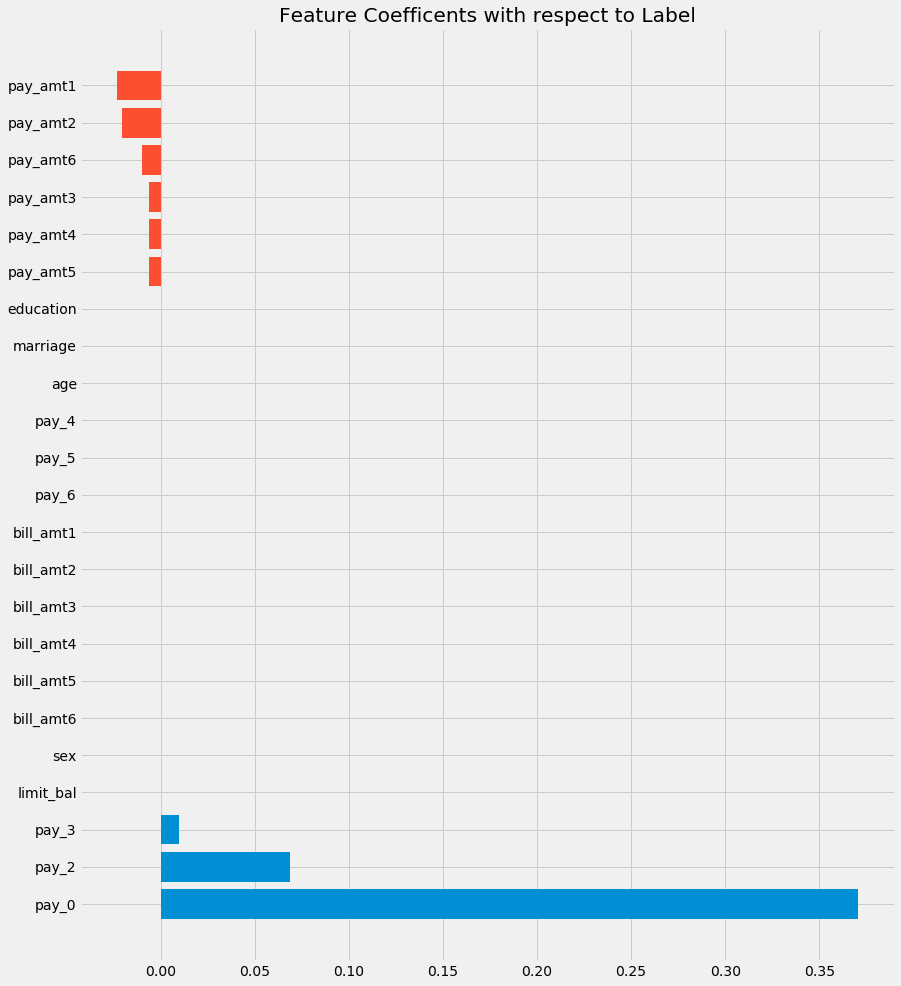

In [163]:
plot_feature_imp(tuned_model,features)

### Conclusion

Using, exploratory analysis, data processing methods, and logistic regression with hyper-parameter tunning we found a best fit model and important features which predict the which clients will default on payment.

This seems to support the [feature selection](#Selection-strategy) we did above.

With the above approach, we predict with ~80% accuracy (and ~50% recall) whether a person will default on an upcoming payment.